In [7]:
# File to extract UoA-DR into directories in the ./data folder - categorised into classes for model training. 
# Modify the data_dir so its is in the tree struction of data_dir -> image_class -> image
# UoA-DR: https://figshare.com/s/5011cb600c8bdbc941f1?file=10741045 

import os

# Expect downloaded images from UoA-DR 
data_dir = 'data/UoA-DR/' 

#  X and Y pairs outlined in https://figshare.com/s/5011cb600c8bdbc941f1?file=10910012
classes_dict = {  
    "NPDR": {*range(1, 82), *range(83, 95), 130, *range(132, 144), *range(168, 170), *range(171, 175), 179, 193},
    "PDR": {82, *range(95, 101), 131, 167, *range(176, 179), *range(182, 193), *range(194, 201)},
    "Healthy": {*range(101, 130), *range(144, 167), 170, 175, *range(180, 182)}
}

In [3]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

# Function to check if a string contains only digits and ends with '.jpg'
def is_retinal_only(file_name):
    return file_name[:-4].isdigit() and file_name.endswith(".jpg")

# Function to find the class of an image given its full filename
def find_class(file_name):
    image_number = file_name[:-4]
    
    for image_class, value_set in classes_dict.items():
        if int(image_number) in value_set:
            print(f"The associated key for {image_number} is: {image_class}")
            break
    else:
        print(f"No associated key found for {image_number}")
    
    return image_class
    
# Create the new folder if it doesn't exist
for image_class in classes_dict.keys():
    new_folder = os.path.join(data_dir, image_class)
    os.makedirs(new_folder, exist_ok=True)

# Modify the data_dir so its is in the tree struction of data_dir -> image_class -> image
for image_folder in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_folder)):
        if is_retinal_only(image):
            image_class = find_class(image)

            # Move the image to the new folder
            original_image_path = os.path.join(data_dir, image_folder, image)
            new_image_path = os.path.join(data_dir, image_class, image)
            os.rename(original_image_path, new_image_path)
            
            print("Original Path:", original_image_path)
            print("New Path:", new_image_path)

KeyboardInterrupt: 

In [17]:
import random
from shutil import copyfile

#create two folders (train and validation)
train_dir = os.path.join(data_dir, 'train2')
os.makedirs(train_dir, exist_ok=True)

validation_dir = os.path.join(data_dir, 'validation')
os.makedirs(validation_dir, exist_ok=True)

#Under train and validation folder create sub folders for each class
for class_name in classes_dict.keys():
    new_train_class_dir = os.path.join(train_dir, class_name)
    new_validation_class_dir = os.path.join(validation_dir, class_name)
    os.makedirs(new_train_class_dir, exist_ok=True)
    os.makedirs(new_validation_class_dir, exist_ok=True)

def split_data(SOURCE, TRAINING, VALIDATION, SPLIT_SIZE):
    files = []
    for image_name in os.listdir(SOURCE):
        file = os.path.join(SOURCE, image_name)
        if os.path.getsize(file) > 0:
            files.append(image_name)
        else:
            print(image_name + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    valid_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    valid_set = shuffled_set[training_length:]

    for filename in training_set:
        this_file = os.path.join(SOURCE, filename)
        destination = os.path.join(TRAINING, filename)
        copyfile(this_file, destination)

    for filename in valid_set:
        this_file = os.path.join(SOURCE, filename)
        destination = os.path.join(VALIDATION, filename)
        copyfile(this_file, destination)

SOURCE_HEALTHY_DIR = os.path.join(data_dir, "Healthy")
SOURCE_NPDR_DIR = os.path.join(data_dir, "NPDR")
SOURCE_PDR_DIR = os.path.join(data_dir, "PDR")

TRAIN_HEALTHY_DIR = os.path.join(train_dir, "Healthy")
TRAIN_NPDR_DIR = os.path.join(train_dir, "NPDR")
TRAIN_PDR_DIR = os.path.join(train_dir, "PDR")

VALID_HEALTHY_DIR = os.path.join(validation_dir, "Healthy")
VALID_NPDR_DIR = os.path.join(validation_dir, "NPDR")
VALID_PDR_DIR = os.path.join(validation_dir, "PDR")

ALL_DIR = [
    [SOURCE_HEALTHY_DIR, TRAIN_HEALTHY_DIR, VALID_HEALTHY_DIR],
    [SOURCE_NPDR_DIR, TRAIN_NPDR_DIR, VALID_NPDR_DIR],
    [SOURCE_PDR_DIR, TRAIN_NPDR_DIR, VALID_PDR_DIR]
]

split_size = .85

for class_folders in ALL_DIR:
    source, train, validation = class_folders
    split_data(source, train, validation, split_size)

['147.jpg', '127.jpg', '102.jpg', '110.jpg', '166.jpg', '108.jpg', '163.jpg', '170.jpg', '148.jpg', '145.jpg', '161.jpg', '181.jpg', '175.jpg', '103.jpg', '116.jpg', '154.jpg', '146.jpg', '125.jpg', '160.jpg', '121.jpg', '118.jpg', '152.jpg', '106.jpg', '101.jpg', '151.jpg', '107.jpg', '122.jpg', '105.jpg', '156.jpg', '119.jpg', '144.jpg', '104.jpg', '124.jpg', '149.jpg', '150.jpg', '114.jpg', '112.jpg', '117.jpg', '162.jpg', '158.jpg', '115.jpg', '159.jpg', '123.jpg', '120.jpg', '165.jpg', '164.jpg', '129.jpg', '153.jpg', '128.jpg', '180.jpg', '109.jpg', '155.jpg', '111.jpg', '126.jpg', '113.jpg', '157.jpg']
['5.jpg', '61.jpg', '7.jpg', '17.jpg', '134.jpg', '10.jpg', '168.jpg', '70.jpg', '51.jpg', '172.jpg', '40.jpg', '31.jpg', '18.jpg', '132.jpg', '26.jpg', '84.jpg', '15.jpg', '87.jpg', '41.jpg', '55.jpg', '130.jpg', '22.jpg', '66.jpg', '12.jpg', '53.jpg', '54.jpg', '13.jpg', '78.jpg', '139.jpg', '52.jpg', '33.jpg', '83.jpg', '32.jpg', '85.jpg', '35.jpg', '69.jpg', '133.jpg', '72.jpg

{'NPDR': 17, 'PDR': 5, 'Healthy': 9}


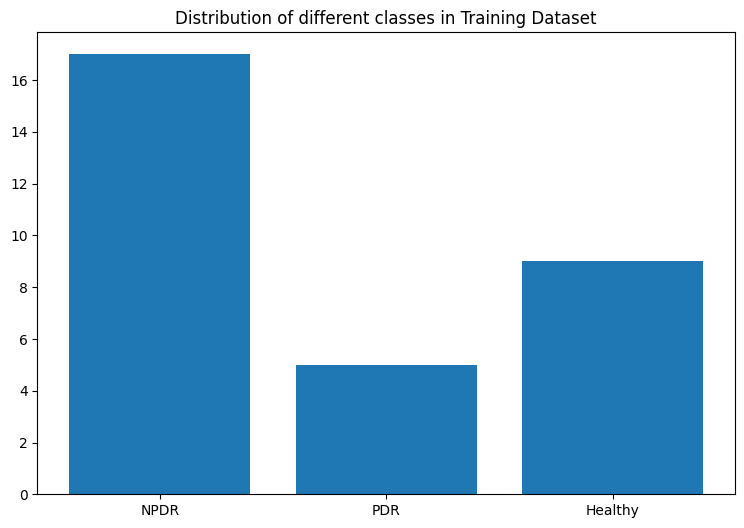

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
import pathlib

nimgs = {}
for class_folder in classes_dict.keys():
    # nimages = len(os.listdir(train_dir+i+'/'))
    nimages = len(os.listdir(os.path.join(validation_dir, class_folder)))
    nimgs[class_folder]=nimages

print(nimgs)
plt.figure(figsize=(9, 6))
plt.bar(range(len(nimgs)), list(nimgs.values()), align='center')
plt.xticks(range(len(nimgs)), list(nimgs.keys()))
plt.title('Distribution of different classes in Training Dataset')
plt.show()

In [9]:
import csv

# Create a list to store rows of data
data_rows = []

# Iterate through the dictionary and create rows
for class_name, values in classes_dict.items():
    for value in values:
        # Initialize the one-hot encoding columns
        one_hot_encoding = {
            "NPDR": 0,
            "PDR": 0,
            "Healthy": 0,
        }
        one_hot_encoding[class_name] = 1
        
        # Append the row to the data_rows list
        data_rows.append([str(value), class_name, one_hot_encoding["Healthy"], one_hot_encoding["NPDR"], one_hot_encoding["PDR"]])

# Write the data to a CSV file
csv_filename = "UoA-DR-labels.csv"
csv_file_path = os.path.join(data_dir, csv_filename)

with open(csv_file_path, "w", newline="") as csvfile:
    csv_writer = csv.writer(csvfile)
    
    # Write the header row
    csv_writer.writerow(["Image Number", "Class", "Healthy", "NPDR", "PDR"])
    
    # Write the data rows
    csv_writer.writerows(data_rows)

print("CSV file created:", csv_file_path)


CSV file created: data/UoA-DR/UoA-DR-labels.csv
